# Проект "риск инфаркта"

## 1. Загрузка требуемых библиотек

In [65]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.model_selection import (
    RandomizedSearchCV
)
from sklearn.preprocessing import (
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    make_scorer,
    confusion_matrix
)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## 2. Загрузка данных

In [34]:
test_data_path = os.path.join('data', 'heart_test.csv')
test_data = pd.read_csv(test_data_path)
print(test_data.head(3))

   Unnamed: 0       Age  Cholesterol  Heart rate  Diabetes  Family History  \
0           0  0.494382     0.264286    0.062328       0.0             1.0   
1           1  0.224719     0.953571    0.082493       1.0             0.0   
2           2  0.629213     0.092857    0.064161       0.0             1.0   

   Smoking  Obesity  Alcohol Consumption  Exercise Hours Per Week  ...  \
0      1.0      1.0                  1.0                 0.361618  ...   
1      0.0      1.0                  0.0                 0.996483  ...   
2      1.0      1.0                  0.0                 0.995561  ...   

   Triglycerides  Physical Activity Days Per Week  Sleep Hours Per Day  \
0       0.306494                              1.0             0.333333   
1       0.087013                              0.0             0.166667   
2       0.205195                              7.0             1.000000   

   Blood sugar     CK-MB  Troponin  Gender  Systolic blood pressure  \
0     0.227018  0.0482

In [35]:
train_data_path = os.path.join('data', 'heart_train.csv')
train_data = pd.read_csv(train_data_path)
print(train_data.head(3))

   Unnamed: 0       Age  Cholesterol  Heart rate  Diabetes  Family History  \
0           0  0.359551     0.732143    0.074244       1.0             1.0   
1           1  0.202247     0.325000    0.047663       1.0             1.0   
2           2  0.606742     0.860714    0.055912       1.0             0.0   

   Smoking  Obesity  Alcohol Consumption  Exercise Hours Per Week  ...  \
0      1.0      1.0                  1.0                 0.535505  ...   
1      0.0      0.0                  1.0                 0.068690  ...   
2      1.0      1.0                  1.0                 0.944001  ...   

   Physical Activity Days Per Week  Sleep Hours Per Day  \
0                              3.0             0.333333   
1                              3.0             0.833333   
2                              2.0             1.000000   

   Heart Attack Risk (Binary)  Blood sugar     CK-MB  Troponin  Gender  \
0                         0.0     0.227018  0.048229  0.036512    Male   
1    

## 3. Предобработка данных

### 3.1 train data

In [36]:
print(train_data.head(3))
print(train_data.info())

   Unnamed: 0       Age  Cholesterol  Heart rate  Diabetes  Family History  \
0           0  0.359551     0.732143    0.074244       1.0             1.0   
1           1  0.202247     0.325000    0.047663       1.0             1.0   
2           2  0.606742     0.860714    0.055912       1.0             0.0   

   Smoking  Obesity  Alcohol Consumption  Exercise Hours Per Week  ...  \
0      1.0      1.0                  1.0                 0.535505  ...   
1      0.0      0.0                  1.0                 0.068690  ...   
2      1.0      1.0                  1.0                 0.944001  ...   

   Physical Activity Days Per Week  Sleep Hours Per Day  \
0                              3.0             0.333333   
1                              3.0             0.833333   
2                              2.0             1.000000   

   Heart Attack Risk (Binary)  Blood sugar     CK-MB  Troponin  Gender  \
0                         0.0     0.227018  0.048229  0.036512    Male   
1    

**Вывод:**
* имеются пропущенные значения;
* неккоретные заголовки (необходимо перевести в 'camel_case');
* 'id' необходимо перенести в индекс;
* все признаки кроме 'gender' - количественные (int, float);
* 'Unnamed: 0' - лишний столбец.

In [37]:
# удаляем признак 'Unnamed: 0'
train_data = train_data.drop('Unnamed: 0', axis=1)

# переносим 'id' в индекс
train_data = train_data.set_index('id', drop=True)

# переименуем столбцы в 'camel_case'
def to_camel_type(string):
    return ['_'.join(w.lower().replace('-', '').split()) for w in string]

train_data.columns = to_camel_type(train_data.columns)

# удаляем пропущенные значения
train_data = train_data.dropna()

# удаляем явные дубликаты
train_data.drop_duplicates()

print(train_data.head(3))

           age  cholesterol  heart_rate  diabetes  family_history  smoking  \
id                                                                           
2664  0.359551     0.732143    0.074244       1.0             1.0      1.0   
9287  0.202247     0.325000    0.047663       1.0             1.0      0.0   
5379  0.606742     0.860714    0.055912       1.0             0.0      1.0   

      obesity  alcohol_consumption  exercise_hours_per_week  diet  ...  \
id                                                                 ...   
2664      1.0                  1.0                 0.535505     1  ...   
9287      0.0                  1.0                 0.068690     2  ...   
5379      1.0                  1.0                 0.944001     2  ...   

      triglycerides  physical_activity_days_per_week  sleep_hours_per_day  \
id                                                                          
2664       0.979221                              3.0             0.333333   
9287   

### 3.2 test data

In [38]:
print(test_data.head(3))
print(test_data.info())

   Unnamed: 0       Age  Cholesterol  Heart rate  Diabetes  Family History  \
0           0  0.494382     0.264286    0.062328       0.0             1.0   
1           1  0.224719     0.953571    0.082493       1.0             0.0   
2           2  0.629213     0.092857    0.064161       0.0             1.0   

   Smoking  Obesity  Alcohol Consumption  Exercise Hours Per Week  ...  \
0      1.0      1.0                  1.0                 0.361618  ...   
1      0.0      1.0                  0.0                 0.996483  ...   
2      1.0      1.0                  0.0                 0.995561  ...   

   Triglycerides  Physical Activity Days Per Week  Sleep Hours Per Day  \
0       0.306494                              1.0             0.333333   
1       0.087013                              0.0             0.166667   
2       0.205195                              7.0             1.000000   

   Blood sugar     CK-MB  Troponin  Gender  Systolic blood pressure  \
0     0.227018  0.0482

**Вывод:** выявленные проблемы аналогичны датасету 'train_data'

In [39]:
# удаляем признак 'Unnamed: 0'
test_data = test_data.drop('Unnamed: 0', axis=1)

# переносим 'id' в индекс
test_data = test_data.set_index('id', drop=True)

# переименуем столбцы в 'camel_case'
test_data.columns = to_camel_type(test_data.columns)

# удаляем пропущенные значения
test_data = test_data.dropna()

# удаляем явные дубликаты
test_data.drop_duplicates()

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ckmb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
id,,,,,,,,,,,,,,,,,,,,,
7746,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,...,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093
4202,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,...,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860
6632,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,...,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070
4639,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,...,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814
4825,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,...,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9271,0.640449,0.235714,0.064161,1.0,0.0,1.0,0.0,1.0,0.449213,2,...,0.164893,0.283117,5.0,0.000000,0.110672,0.049750,0.000777,Male,0.425806,0.744186
8012,0.516854,0.367857,0.063245,1.0,0.0,1.0,0.0,0.0,0.563595,0,...,0.242904,0.422078,2.0,0.000000,0.114625,0.008706,0.001456,Male,0.651613,0.697674
2456,0.213483,0.596429,0.076994,1.0,0.0,1.0,1.0,1.0,0.549976,0,...,0.662209,0.914286,4.0,0.666667,0.227018,0.048229,0.036512,Male,0.696774,0.767442


## 4. Исследовательский анализ данных

### 4.1 Анализ признаков с точки зрения их природы

Перед проведением количественного исследовательского анализа данных необходимо рассмотреть показатели через призму современных стандартов и рекомендаций ВОЗ и доступных кардиологических исследований ([статья в Википедия](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%84%D0%B0%D1%80%D0%BA%D1%82_%D0%BC%D0%B8%D0%BE%D0%BA%D0%B0%D1%80%D0%B4%D0%B0#%D0%A4%D0%B0%D0%BA%D1%82%D0%BE%D1%80%D1%8B_%D1%80%D0%B8%D1%81%D0%BA%D0%B0)).
Рассмотрим показатели через призму их природы на предмет дублирования, а также возможных утечек целевого признака.


|#| Название признака| Описание признака |
|:--:|:-------------|:-------------|
|1|'age'|возраст|
|2|'cholesterol'|холестерин|
|3|'heart_rate'|частота сердечных сокращений (пульс)|
|4|'diabetes'|наличие диабета|
|5|'family_history'|семейный анамнез (наличие проблем у родственников)|
|6|'smoking'|статус курения|
|7|'obesity'|ожирение|
|8|'alcohol_consumption'|употребление алкоголя|
|9|'exercise_hours_per_week'|количество часов физической активности в неделю|
|10|'diet'|режим питания (диета)|
|11|'previous_heart_problems'|история сердечных заболеваний|
|12|'medication_use'|использование лекарств, связанных с сердцем или другими заболеваниями|
|13|'stress_level'|уровень стресса|
|14|'sedentary_hours_per_day'|время, проведенное в малоподвижном состоянии|
|15|'income'|уровень дохода|
|16|'bmi'|индекс массы тела (ИМТ)|
|17|'triglycerides'|уровень триглицеридов в крови|
|18|'physical_activity_days_per_week'|количество дней физической активности в неделю|
|19|'sleep_hours_per_day'|среднее количество часов сна в сутки|
|20|**'heart_attack_risk_(binary)'**|**риск сердечного приступа (таргет)**|
|21|'blood_sugar'|уровень сахара в крови|
|22|'ckmb'|Креатинкиназа-МВ (биомаркер повреждения сердечной мышцы)|
|23|'troponin'|тропонин (биомаркер сердечного повреждения)|
|24|'gender'|пол|
|25|'systolic_blood_pressure'|систолическое артериальное давление (верхнее значение давления)|
|26|'diastolic_blood_pressure'|диастолическое артериальное давление (нижнее значение давления)|

**Выводы:**
 * 'sedentary_hours_per_day' и 'physical_activity_days_per_week' и 'exercise_hours_per_week' — первый отражает малоподвижность, второй и третий — активность. Эти признаки противоположны по смыслу и могут быть скоррелированы.

 * 'bmi' и 'obesity' — оба показателя связаны с массой тела.

 * 'cholesterol' и 'triglycerides' — разные биохимические показатели и относятся к липидному обмену, не являются дублями, но могут быть скоррелированы.

 * 'previous_heart_problems' и 'heart_attack_risk_(binary)' — первый признак отражает наличие ранее выявленных проблем с сердцем, второй — риск инфаркта. Эти показатели связаны между собой по смыслу. В признаке 'previous_heart_problems' возможно наличие утечки целевого признака.

### 4.2 Количественный анализ

In [40]:
train_data['gender'].unique()

array(['Male', 'Female'], dtype=object)

In [41]:
# осуществим замену бинарного категориального признака 'gender' на "1 / 0"
train_data['gender'] = train_data['gender'].map({'Male': 1, 'Female': 0})
test_data['gender'] = test_data['gender'].map({'Male': 1, 'Female': 0})

In [42]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,8442.0,0.449008,0.232809,0.044944,0.247191,0.460674,0.640449,0.853933
cholesterol,8442.0,0.501108,0.288785,0.000000,0.260714,0.496429,0.750000,1.000000
heart_rate,8442.0,0.050194,0.018442,0.018332,0.034830,0.050412,0.065995,0.082493
diabetes,8442.0,0.652097,0.476333,0.000000,0.000000,1.000000,1.000000,1.000000
family_history,8442.0,0.489576,0.499921,0.000000,0.000000,0.000000,1.000000,1.000000
smoking,8442.0,0.902867,0.296157,0.000000,1.000000,1.000000,1.000000,1.000000
obesity,8442.0,0.498342,0.500027,0.000000,0.000000,0.000000,1.000000,1.000000
alcohol_consumption,8442.0,0.601990,0.489517,0.000000,0.000000,1.000000,1.000000,1.000000
exercise_hours_per_week,8442.0,0.503415,0.288881,0.000000,0.253359,0.508244,0.754901,1.000000
diet,8442.0,1.001540,0.812981,0.000000,0.000000,1.000000,2.000000,2.000000


In [43]:
# подготовка данных и добавление признака типа датасета
train_data['type'] = 'train'
test_data['type'] = 'test'

# обьединение
total_data = pd.concat([train_data, test_data], axis=0)

In [44]:
def complex_plot_cont(data, xlabel_def):
    # данные для графика
    data1 = data.query('type=="train"')[xlabel_def]
    data2 = data.query('type=="test"')[xlabel_def]
    
    # отрисовка графика
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data1, label='train', fill=True, alpha=0.5)
    sns.kdeplot(data2, label='test', fill=True, alpha=0.5)
    plt.legend()
    plt.title(f'Сравнение распределений двух выборок: {xlabel_def}')
    plt.xlabel('Значения')
    plt.ylabel('Плотность')
    plt.show()

def complex_plot_cat(data, xlabel_def):
    # данные для графика
    plotdata = total_data[[xlabel_def, 'type']].pivot_table(index=xlabel_def, columns='type', aggfunc='size')
    categories = plotdata.index
    values_train = plotdata['train']
    values_test = plotdata['test']
    
    # отрисовка графика
    fig, ax = plt.subplots(1, 2, figsize=(8, 5))
    print(f"\033[1mГрафик структуры значений: {xlabel_def}\033[1m\n")
    ax[0].pie(values_train, labels=categories, autopct='%1.1f%%', startangle=140)
    ax[0].set_title('train data:')
    ax[1].pie(values_test, labels=categories, autopct='%1.1f%%', startangle=140)
    ax[1].set_title('test data:')
    plt.tight_layout()
    plt.show()

Категориальные признаки:

Количественные признаки:



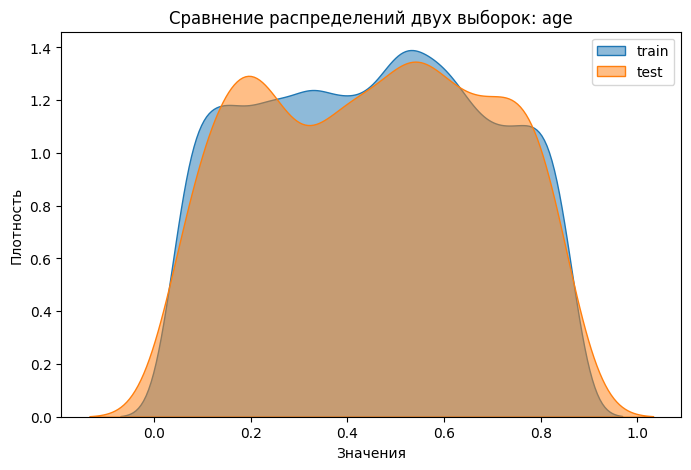

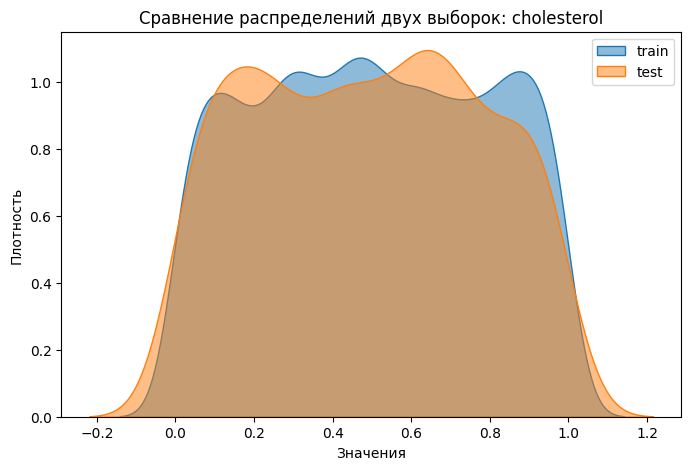

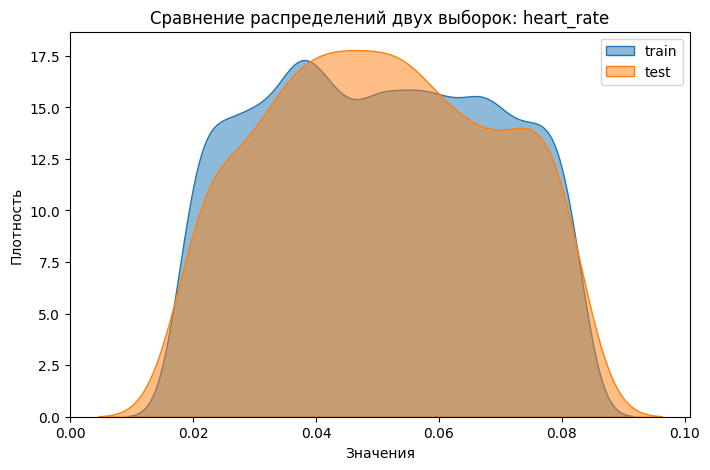

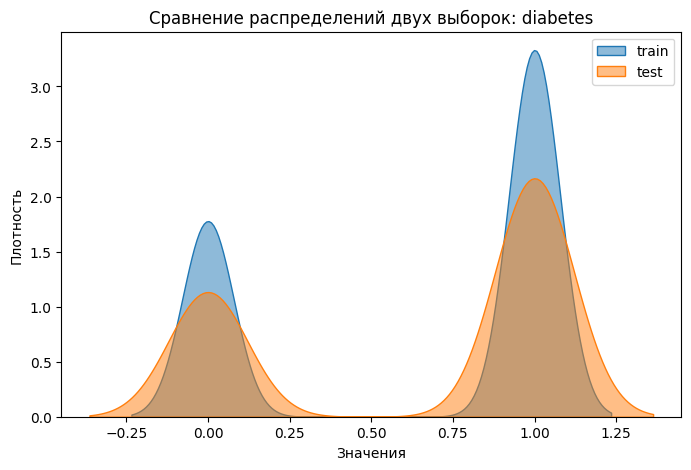

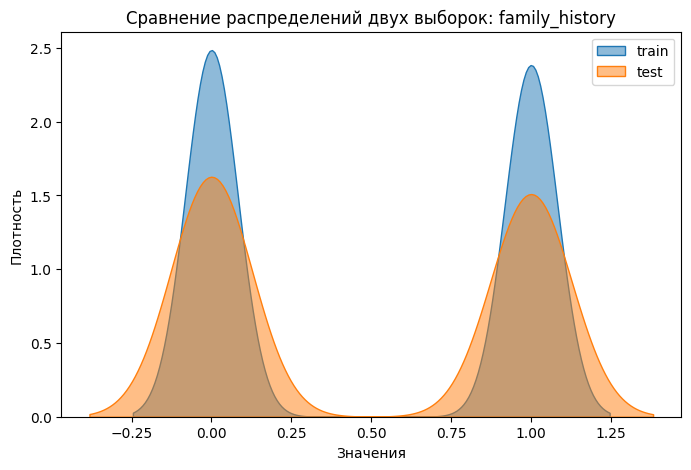

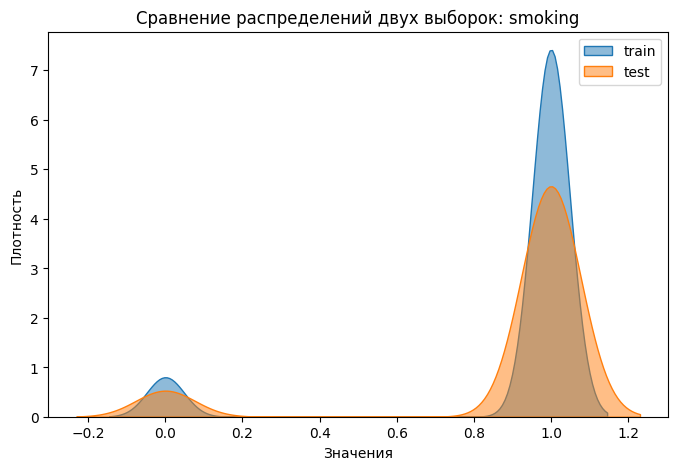

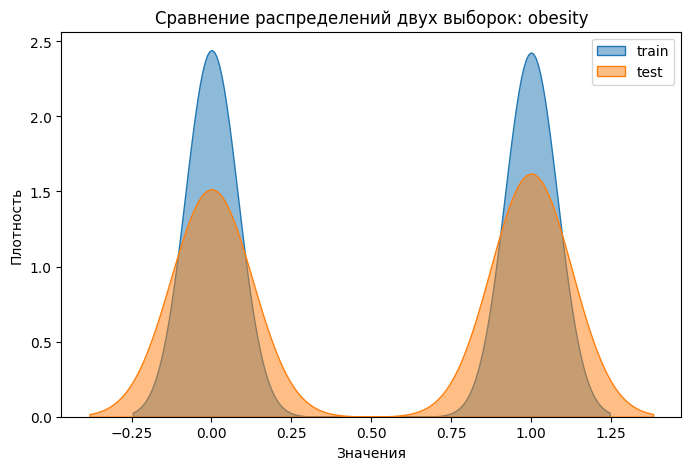

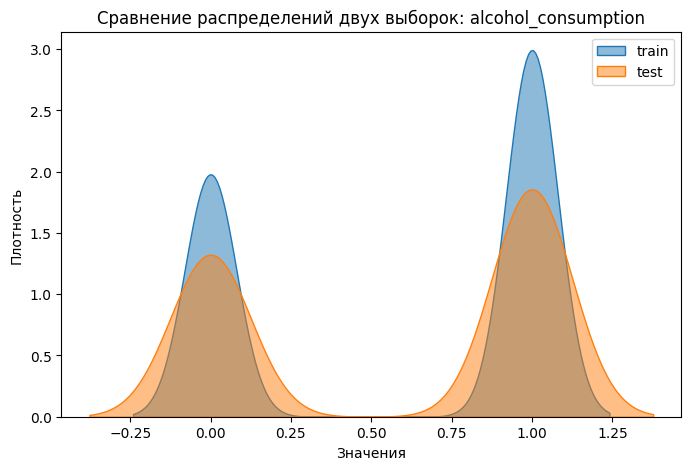

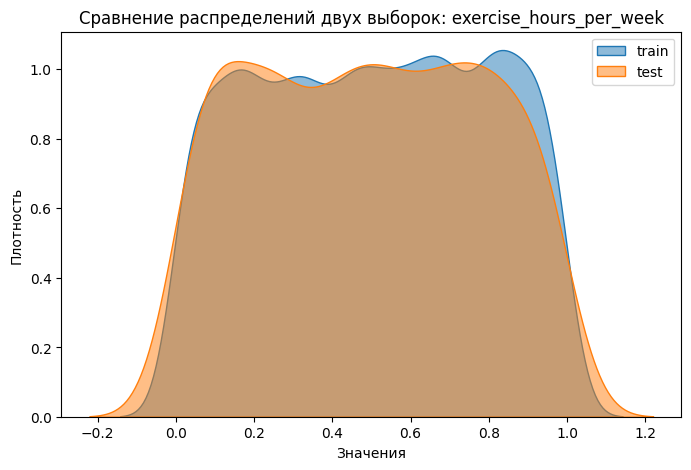

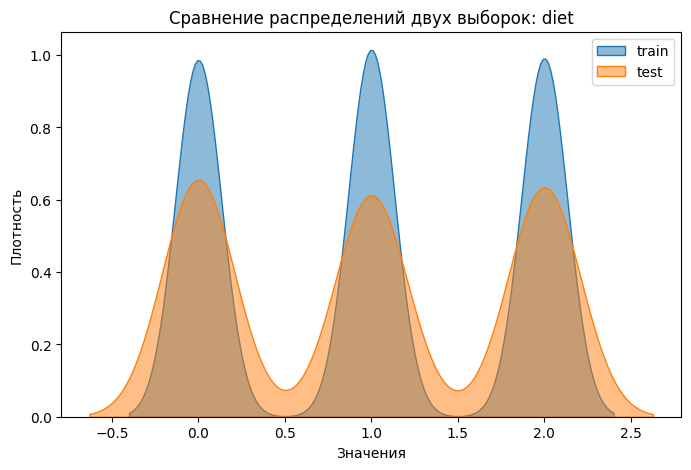

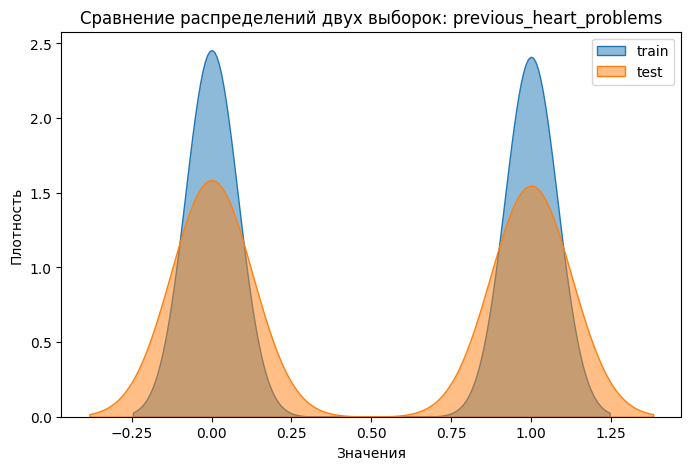

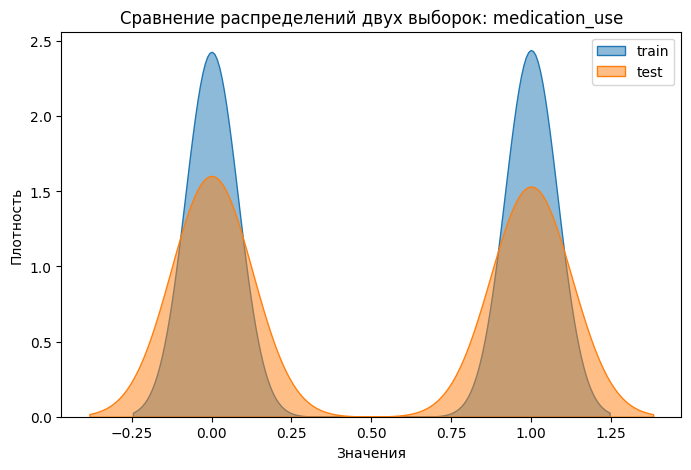

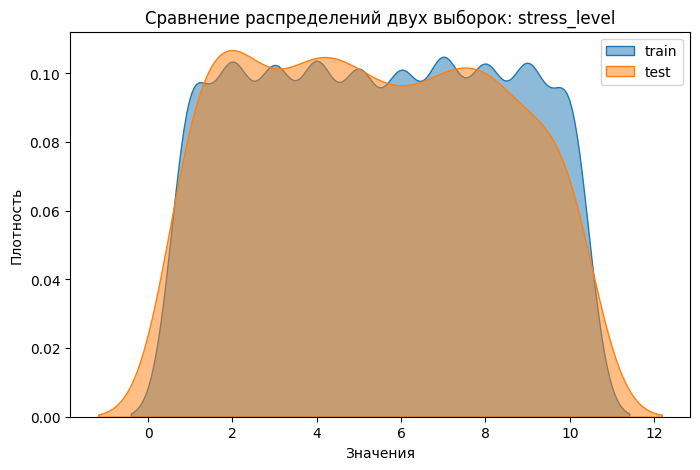

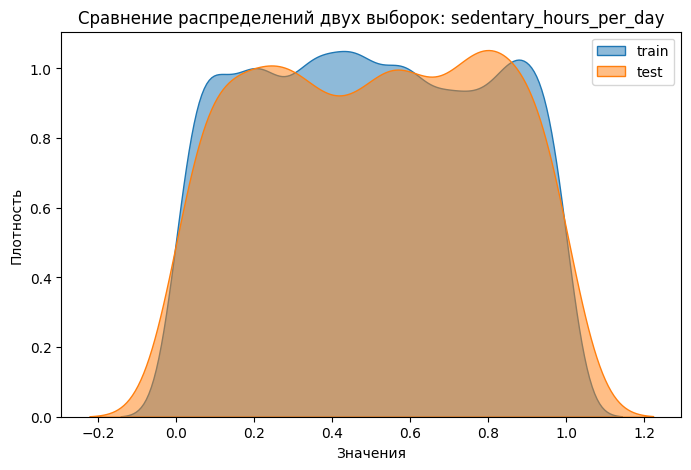

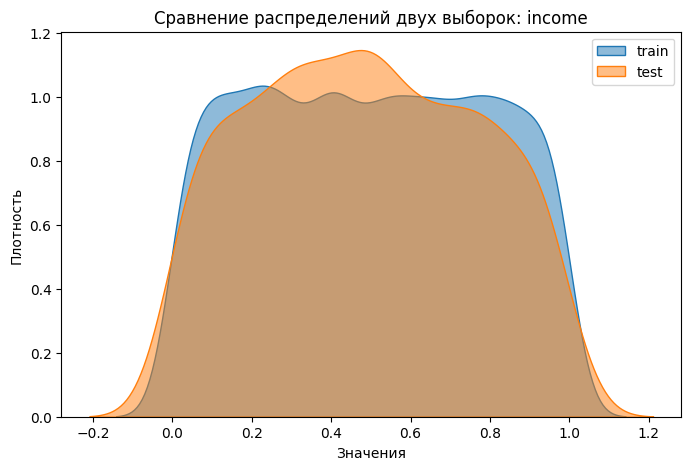

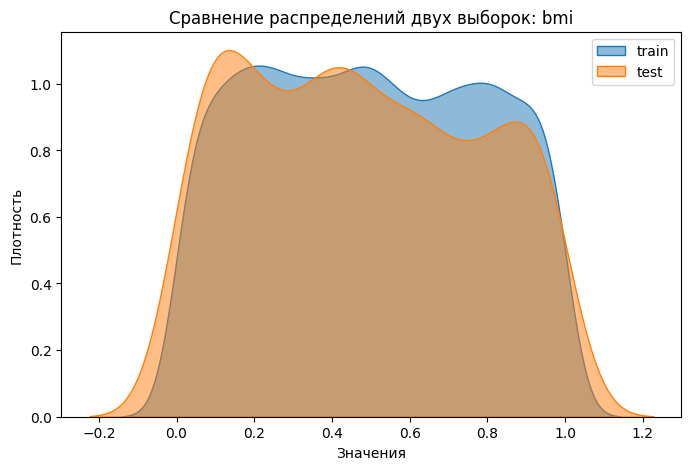

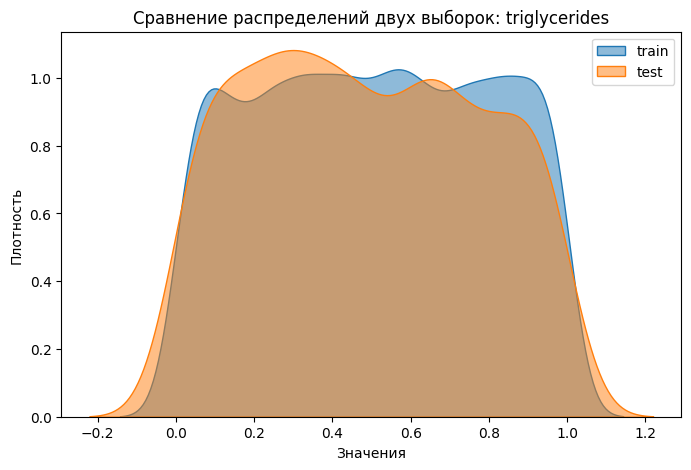

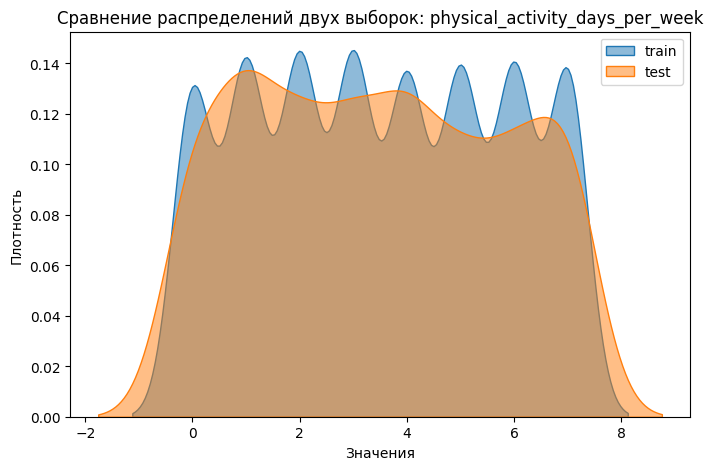

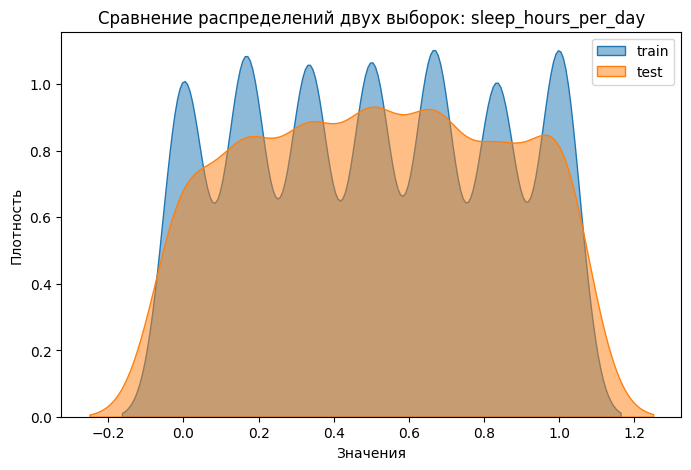

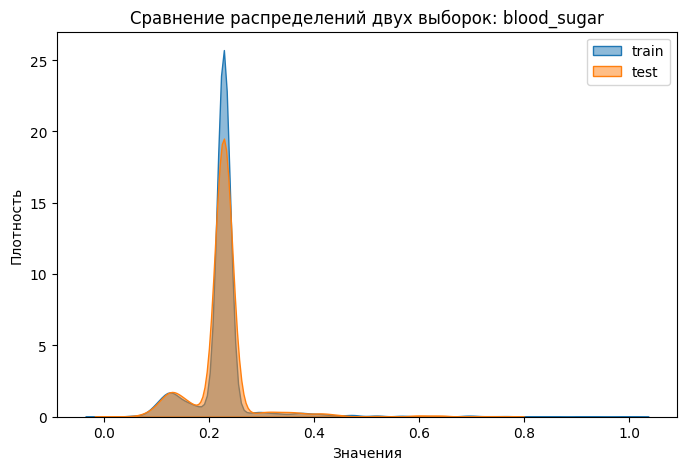

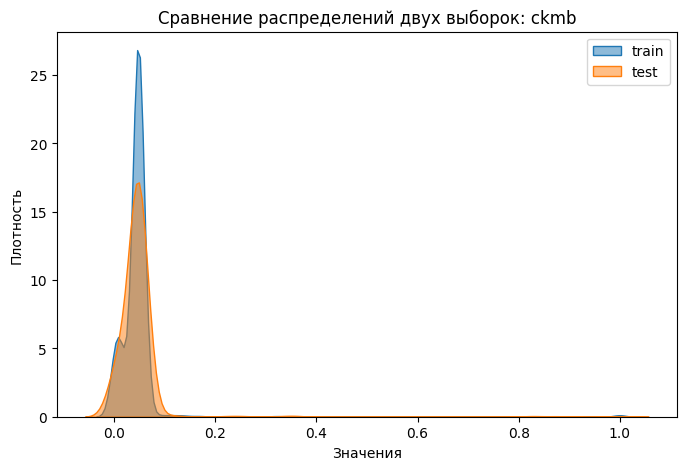

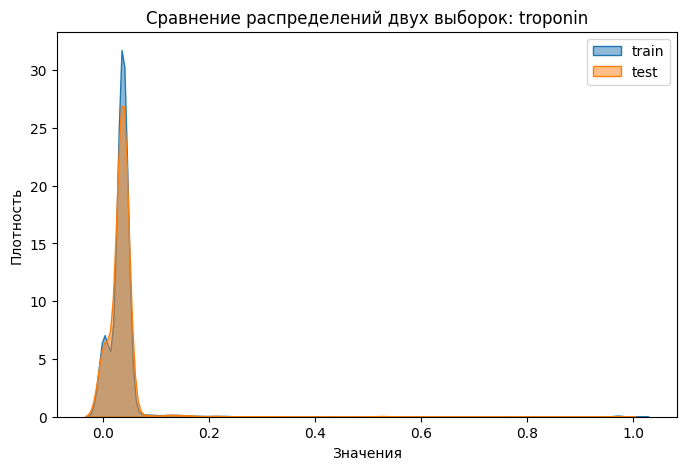

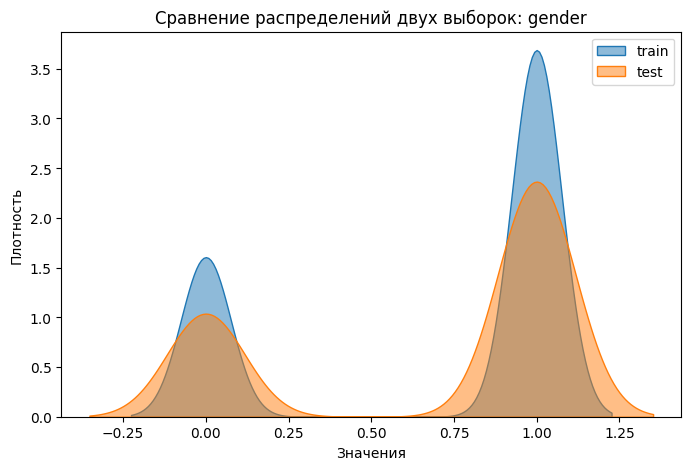

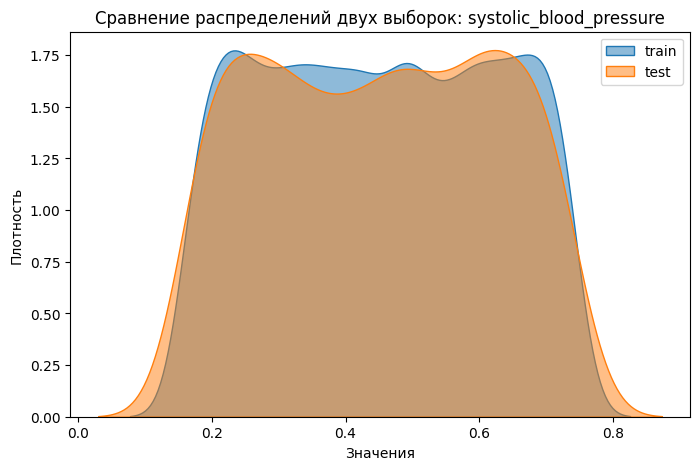

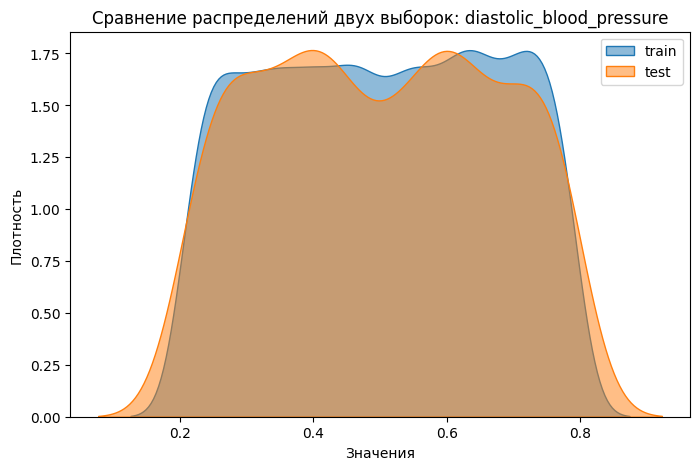

In [45]:

col_num = train_data.select_dtypes(include=['number']).columns.tolist()
col_num = [col for col in col_num if col not in ["heart_attack_risk_(binary)"]]
col_cat = train_data.select_dtypes(include=['object']).columns.tolist()
col_cat = [col for col in col_cat if col not in ['type', "heart_attack_risk_(binary)"]]

print('\033[1mКатегориальные признаки:\033[1m\n')
for col_i in col_cat:
    complex_plot_cat(total_data, col_i)
print('\033[1mКоличественные признаки:\033[1m\n')
for col_i in col_num:
    complex_plot_cont(total_data, col_i)

|Название признака| Описание признака |
|:-------------|:-------------|
|'gender'|выборки имеют сопоставимые структуры по полу|
|'age'<br> 'exercise_hours_per_week'<br>'blood_sugar'<br>'ckmb'<br>'troponin'|масштабированный признак, сопоставимое мультимодальное распределение|
|'cholesterol' <br> 'heart_rate' <br> 'sedentary_hours_per_day'<br>'income'<br>'bmi'<br>'triglycerides'|масштабированный признак, сопоставимое мультимодальное распределение, заметно смещение пиков|
|'diabetes'<br>'family_history'<br>'smoking'<br>'obesity'<br>'alcohol_consumption'<br>'previous_heart_problems'<br>'medication_use'|бинарный признак, наличие более высоких значений в train связано скорее всего с тем, что train имеет большее количество наблюдений|
|'diet'|категориальный признак с 3 категориями, наличие более высоких значений в train связано скорее всего с тем, что train имеет большее количество наблюдений|
|'stress_level'|категориальный признак с 10 категориями, отличие в распределении, связано с тем, что структура распределения признака отличается в train и test|
|'physical_activity_days_per_week'<br>'sleep_hours_per_day'|категориальный признак с 7 категориями, отличие в распределении, отличие в структуре распределения связано с тем, что train содержит большее количество наблюдений|
|'diastolic_blood_pressure'<br>'systolic_blood_pressure'|количественный не масштабированный признак|

### 4.3 Корреляционный анализ

Тренировочная выборка:



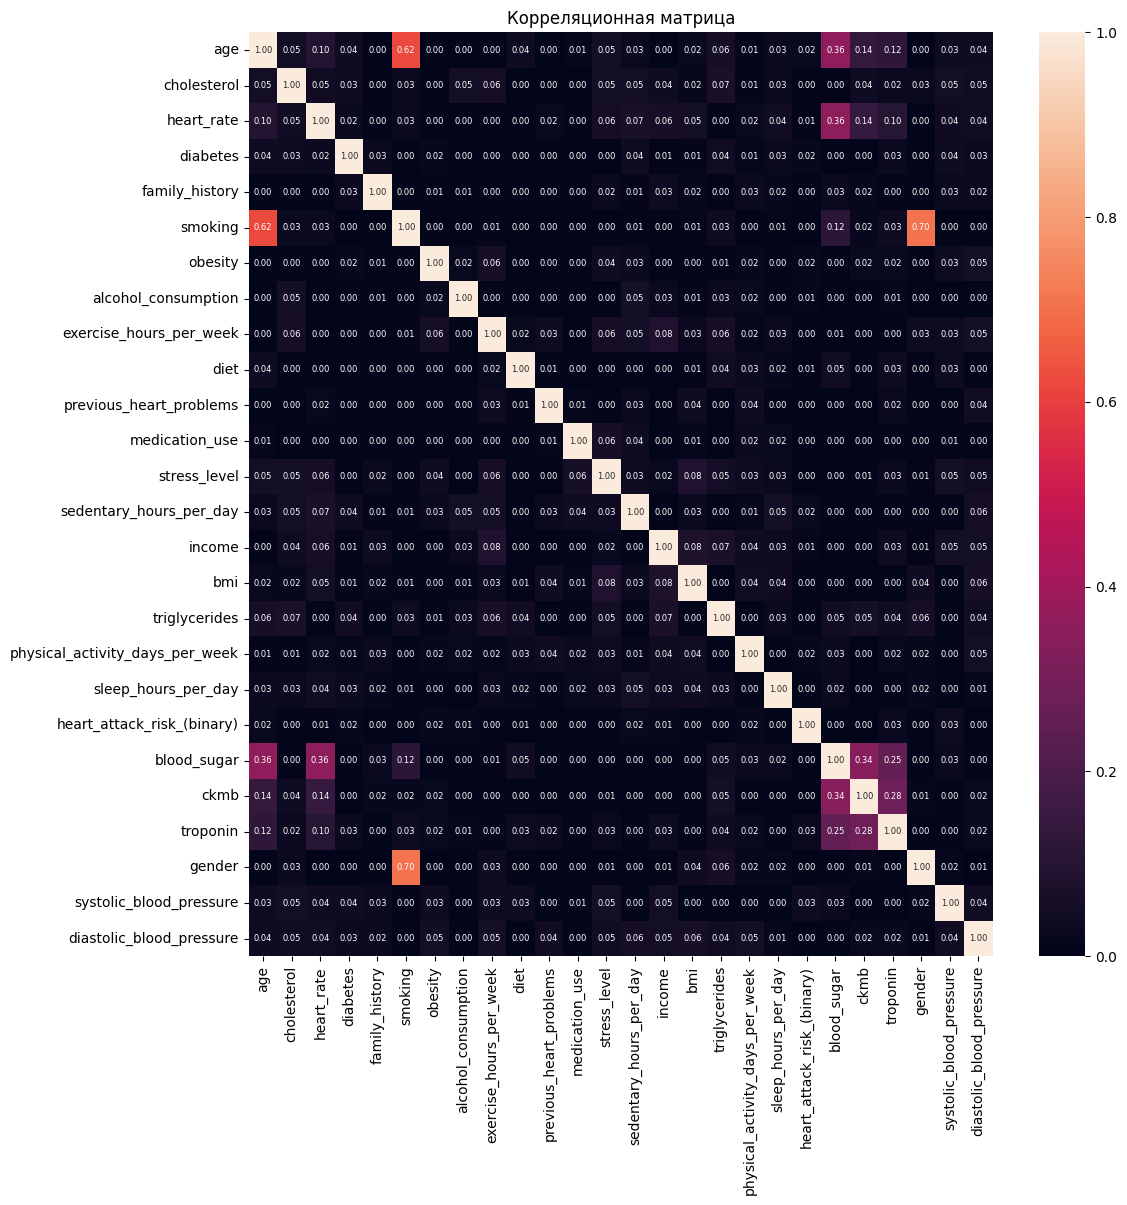

In [12]:
# разделим общий датасет на тренировочную и тестовую выборки
train_df = total_data.query('type=="train"').drop('type', axis=1).copy()

# рассчитаем корреляции признаков
print('Тренировочная выборка:\n')
cor_matrix = train_df.phik_matrix(interval_cols=col_num)
corr_df = pd.DataFrame(cor_matrix,
                       index = train_df.columns, 
                       columns=train_df.columns)
ax, fig = plt.subplots(figsize=(12, 12))
ax=sns.heatmap(corr_df, annot=True, annot_kws={"size": 6}, fmt='.2f')
ax.set_title('Корреляционная матрица')
plt.show()

## 5. Поиск лучшей модели

### 5.1 Подготовка и обработка данных

In [58]:
RANDOM_STATE = 27

# данные для моделирования
X_train = train_data.copy().drop(['heart_attack_risk_(binary)', 'type'], axis=1)
y_train = train_data.copy()['heart_attack_risk_(binary)']
X_test = test_data.copy().drop('type', axis=1)

# списки с названиями признаков
ord_columns = [
    'gender', 'diet', 'stress_level', 'physical_activity_days_per_week', 'sleep_hours_per_day', 'diabetes', 
    'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'previous_heart_problems', 'medication_use'
]
num_columns = [
    'age', 'exercise_hours_per_week', 'blood_sugar', 'ckmb', 'troponin', 'cholesterol',
    'heart_rate', 'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides'
]

In [59]:
# пайплайн для подготовки порядковых признаков 
ord_pipe = Pipeline(
    [
        ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ]
)

num_pipe = Pipeline(
    [
        ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('num', StandardScaler())
    ]
)

# создаем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

# создаем итоговый пайплайн 
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

### 5.2 Финальный пайплайн и перечень моделей

In [60]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [61]:
# создаем список словарей моделей и гиперпараметров для перебора
param_grid = [
    # словарь для KNN
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для DecisionTreeClassifier
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для LogisticRegression
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'models__penalty': ['l1', 'l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словать для SVC
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__degree': range(1, 6),
        'models__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

### 5.3 Поиск лучшей модели

In [62]:
# поиск лучшей комбинации "модель-гиперпараметр"
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=['roc_auc', 'f1', 'accuracy'],
    refit='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
).fit(X_train, y_train)

result = pd.DataFrame(randomized_search.cv_results_)
result_sort = result[
    ['mean_fit_time', 'param_models', 'mean_test_roc_auc', 
     'mean_test_f1', 'mean_test_accuracy',  'rank_test_roc_auc']
].sort_values('rank_test_roc_auc').reset_index(drop=True)

print('Рейтинг моделей по показателю ROC AUC:')
display(result_sort)

Рейтинг моделей по показателю ROC AUC:


,mean_fit_time,param_models,mean_test_roc_auc,mean_test_f1,mean_test_accuracy,rank_test_roc_auc
0,0.067927,KNeighborsClassifier(n_neighbors=3),0.526578,0.347591,0.571904,1
1,0.075370,KNeighborsClassifier(n_neighbors=3),0.523515,0.213199,0.614903,2
2,0.034507,KNeighborsClassifier(n_neighbors=3),0.521858,0.196587,0.613955,3
3,0.038152,KNeighborsClassifier(n_neighbors=3),0.518472,0.269667,0.599150,4
4,0.121781,DecisionTreeClassifier(random_state=27),0.508963,0.097515,0.628878,5
5,0.076642,DecisionTreeClassifier(random_state=27),0.505226,0.072362,0.626631,6
6,0.048002,DecisionTreeClassifier(random_state=27),0.504636,0.059272,0.634685,7
7,0.034508,DecisionTreeClassifier(random_state=27),0.503491,0.115333,0.629591,8
8,0.034509,DecisionTreeClassifier(random_state=27),0.500412,0.082226,0.627104,9
9,0.050718,DecisionTreeClassifier(random_state=27),0.497294,0.003255,0.641673,10


In [63]:
# лучшая модель
best_estimator = randomized_search.best_estimator_
print('Гиперпараметры лучшей модели:\n')
print(best_estimator)
best_model_class = best_estimator['models']
final_preprocessor = best_estimator['preprocessor']
X_test_transformed = final_preprocessor.transform(X_test)
y_pred = best_model_class.predict(X_test_transformed)

Гиперпараметры лучшей модели:

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_num',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['gender', 'diet',
                                                   'stress_level',
                                                   'physical_activity_days_per_week',
                                                   'sleep_hours_per_day',
                              

### 5.4 Анализ важности признаков

In [ ]:
# Вычисление перестановочной важности
results = permutation_importance(best_model_class, X_train, y_train, scoring='accuracy', n_repeats=10)

# Получение важности признаков
feature_names = best_estimator[:-1].get_feature_names_out()
feature_importances = results.importances_mean

# Создание DataFrame с важностью признаков
feature_df = pd.DataFrame(np.column_stack((feature_names, np.round(feature_importances, 2))))
feature_df.columns = ['feature', 'weight']

# Сортировка по важности в убывающем порядке
display(feature_df.sort_values(by='weight', ascending=False))